# Bidirectional LSTM Baseline

I wanted to check that training a sequence model without any linguistic pretraining can resolve the contextual ambiguity between the speech classes in the `HatexPlain Dataset`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from collections import Counter
import json

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset
Used the same preprocessed dataset used in Tf-Idf baseline

In [5]:
train_df = pd.read_csv("../data/baseline/train_base.csv")
val_df   = pd.read_csv("../data/baseline/val_base.csv")
test_df  = pd.read_csv("../data/baseline/test_base.csv")
train_df.head()


,post_id,source,text,label
0,23107796_gab,gab,u really think would not raped feral hindu mus...,offensive
1,9995600_gab,gab,uk threatened return radioactive waste eu agre...,offensive
2,1227920812235051008_twitter,twitter,english not imposition hindi also not impositi...,offensive
3,1204931715778543624_twitter,twitter,no liberal congratulated hindu refugees post c...,offensive
4,1179102559241244672_twitter,twitter,said bro even texts sound redneck whatever fuc...,offensive


### Label Encoding the classes to numeric values to feed

In [6]:
lab_enco = LabelEncoder()

In [7]:
train_df["encoded_label"] = lab_enco.fit_transform(train_df["label"])
val_df["encoded_label"]   = lab_enco.transform(val_df["label"])
test_df["encoded_label"]  = lab_enco.transform(test_df["label"])

In [8]:
lab_enco.classes_

array(['hatespeech', 'normal', 'offensive'], dtype=object)

## Vocab building and encoding 
- Vocab Construction from scratch
- Not used any external pretrained tokenizer
- Implemented sequence encoding and Padding

In [9]:
def vocab(texts,max_vocab=20000):
    cnt = Counter()
    for text in texts:
        cnt.update(text.split())
    most_common = cnt.most_common(max_vocab-2)
    vocab = {"<PAD>":0,"<UNK>":1}
    for i,(word,_) in enumerate(most_common,start=2):
        vocab[word] = i
    return vocab

In [10]:
vocab = vocab(train_df['text'],max_vocab=20000)
len(vocab)

20000

In [11]:
max_words = 100

def encode(text,vocab,max_len):
    tokens = text.split()
    ids = [vocab.get(t,vocab['<UNK>']) for t in tokens][:max_len]
    return ids + [0]*(max_len-len(ids))


In [12]:
train_df["encoded"] = train_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
val_df["encoded"]   = val_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
test_df["encoded"]  = test_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
train_df.sample(5)

,post_id,source,text,label,encoded_label,encoded
13417,1107811924727775238_twitter,twitter,bitch want bday end,offensive,2,"[13, 29, 6817, 245, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6189,1178812941405171713_twitter,twitter,truly amazed twitter allows little racist bitc...,normal,1,"[830, 9203, 95, 1997, 120, 85, 101, 32, 6261, ..."
9230,22148835_gab,gab,mark conditt austinbombing suspect domestic te...,offensive,2,"[1417, 19501, 19502, 2198, 1016, 296, 4369, 94..."
6232,1104896761817112577_twitter,twitter,USER oh moronullah accommodate muslims top rub...,offensive,2,"[2, 118, 16957, 6348, 55, 541, 16958, 275, 255..."
12993,1179028889265418240_twitter,twitter,USER white thumbs_up medium light_skin_tone fi...,normal,1,"[2, 4, 2094, 753, 485, 1, 3, 6879, 76, 1248, 4..."


## Pytorch dataset loader class 

In [13]:
class TextDataset(Dataset):
    def __init__(self,df):
        self.texts = df["encoded"].tolist()
        self.labels = df["encoded_label"].tolist()
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return (torch.tensor(self.texts[idx],dtype=torch.long),torch.tensor(self.labels[idx],dtype=torch.long))

In [14]:
train_ds = TextDataset(train_df)
val_ds   = TextDataset(val_df)
test_ds  = TextDataset(test_df)

In [15]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

## BiLSTM model architecture
- It has randomly initialized embedding layer
- A bidirectional LSTM encoder
- A fully connected classification layer

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dimen, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dimen, padding_idx=0)
        self.lstm = nn.LSTM(embed_dimen, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
    
    def forward(self,x):
        x = self.embedding(x)
        out,_ = self.lstm(x)
        out = out.mean(dim=1)
        return self.fc(out)

In [17]:
model = BiLSTM(vocab_size=len(vocab),embed_dimen=100,hidden_dim=128,num_classes=3).to(device)
model

BiLSTM(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

### Model Training 
- Used `CrossEntropyLoss` and `Adam Optimizer` to train the model
- Used Validation Set to monitor how model generalizes and overfits

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [20]:
def eval(model, loader):
    model.eval()
    preds, labels = [], []
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
             
    return preds, labels


In [21]:
def val(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
    return total_loss / len(loader)

## Model training and observation of losses/epoch

In [22]:
train_loss,val_loss = [],[]
EPOCHS = 25
for epoch in range(EPOCHS):
    tloss = train(model, train_loader)
    vloss = val(model,val_loader)
    train_loss.append(tloss)
    val_loss.append(vloss)
    print(f"Epoch {epoch+1} | Train Loss: {tloss:.4f} | Val Loss: {vloss:.4f}")

100%|██████████| 241/241 [00:02<00:00, 104.55it/s]


Epoch 1 | Train Loss: 1.0019 | Val Loss: 0.9370


100%|██████████| 241/241 [00:02<00:00, 118.24it/s]


Epoch 2 | Train Loss: 0.8545 | Val Loss: 0.8611


100%|██████████| 241/241 [00:02<00:00, 117.42it/s]


Epoch 3 | Train Loss: 0.7541 | Val Loss: 0.8057


100%|██████████| 241/241 [00:02<00:00, 114.17it/s]


Epoch 4 | Train Loss: 0.6452 | Val Loss: 0.8684


100%|██████████| 241/241 [00:02<00:00, 113.83it/s]


Epoch 5 | Train Loss: 0.5451 | Val Loss: 0.9142


100%|██████████| 241/241 [00:02<00:00, 113.04it/s]


Epoch 6 | Train Loss: 0.4379 | Val Loss: 1.0316


100%|██████████| 241/241 [00:02<00:00, 114.78it/s]


Epoch 7 | Train Loss: 0.3370 | Val Loss: 1.1606


100%|██████████| 241/241 [00:02<00:00, 118.65it/s]


Epoch 8 | Train Loss: 0.2644 | Val Loss: 1.3910


100%|██████████| 241/241 [00:02<00:00, 117.61it/s]


Epoch 9 | Train Loss: 0.2054 | Val Loss: 1.5081


100%|██████████| 241/241 [00:02<00:00, 117.79it/s]


Epoch 10 | Train Loss: 0.1591 | Val Loss: 1.6434


100%|██████████| 241/241 [00:02<00:00, 116.70it/s]


Epoch 11 | Train Loss: 0.1328 | Val Loss: 1.8953


100%|██████████| 241/241 [00:02<00:00, 113.89it/s]


Epoch 12 | Train Loss: 0.0981 | Val Loss: 2.1375


100%|██████████| 241/241 [00:02<00:00, 110.71it/s]


Epoch 13 | Train Loss: 0.0828 | Val Loss: 1.9749


100%|██████████| 241/241 [00:02<00:00, 110.98it/s]


Epoch 14 | Train Loss: 0.0838 | Val Loss: 2.1691


100%|██████████| 241/241 [00:02<00:00, 113.06it/s]


Epoch 15 | Train Loss: 0.0596 | Val Loss: 2.5503


100%|██████████| 241/241 [00:02<00:00, 110.87it/s]


Epoch 16 | Train Loss: 0.0469 | Val Loss: 3.0238


100%|██████████| 241/241 [00:02<00:00, 110.64it/s]


Epoch 17 | Train Loss: 0.0411 | Val Loss: 2.7359


100%|██████████| 241/241 [00:02<00:00, 110.67it/s]


Epoch 18 | Train Loss: 0.0355 | Val Loss: 2.8408


100%|██████████| 241/241 [00:02<00:00, 113.83it/s]


Epoch 19 | Train Loss: 0.0445 | Val Loss: 2.6946


100%|██████████| 241/241 [00:02<00:00, 111.93it/s]


Epoch 20 | Train Loss: 0.0310 | Val Loss: 2.9206


100%|██████████| 241/241 [00:02<00:00, 114.12it/s]


Epoch 21 | Train Loss: 0.0205 | Val Loss: 3.1774


100%|██████████| 241/241 [00:02<00:00, 111.30it/s]


Epoch 22 | Train Loss: 0.0192 | Val Loss: 3.2975


100%|██████████| 241/241 [00:02<00:00, 113.29it/s]


Epoch 23 | Train Loss: 0.0243 | Val Loss: 3.2789


100%|██████████| 241/241 [00:02<00:00, 113.59it/s]


Epoch 24 | Train Loss: 0.0311 | Val Loss: 3.1858


100%|██████████| 241/241 [00:02<00:00, 114.52it/s]


Epoch 25 | Train Loss: 0.0247 | Val Loss: 3.4028


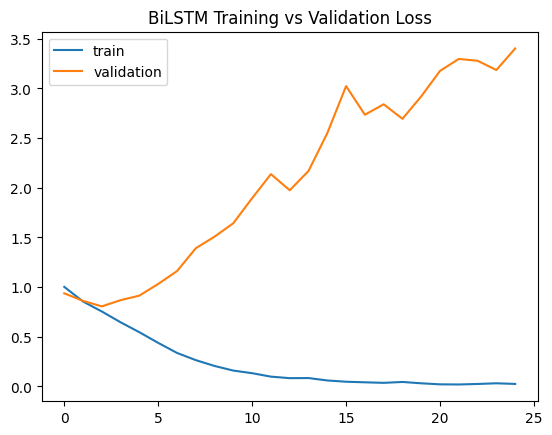

In [ ]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.legend()
plt.title("BiLSTM Training vs Validation Loss")
plt.savefig("../figures/bilstm_training_loss.png",dpi=300,bbox_inches="tight" )
plt.show()

## Model Evaluation

- Evaluated the model on test set using `precision`, `recall`,`F1-Score` and `Confusion Matrix`

In [24]:
y_pred,y_true = eval(model,test_loader)

class_repo = classification_report(y_true,y_pred,target_names=lab_enco.classes_,digits=4,output_dict=True)
print(class_repo)

{'hatespeech': {'precision': 0.7145748987854251, 'recall': 0.5942760942760943, 'f1-score': 0.6488970588235294, 'support': 594.0}, 'normal': {'precision': 0.6072234762979684, 'recall': 0.6879795396419437, 'f1-score': 0.645083932853717, 'support': 782.0}, 'offensive': {'precision': 0.4375, 'recall': 0.4343065693430657, 'f1-score': 0.4358974358974359, 'support': 548.0}, 'accuracy': 0.5867983367983368, 'macro avg': {'precision': 0.5864327916944645, 'recall': 0.5721874010870346, 'f1-score': 0.5766261425248941, 'support': 1924.0}, 'weighted avg': {'precision': 0.5920250771016392, 'recall': 0.5867983367983368, 'f1-score': 0.5866799809275354, 'support': 1924.0}}


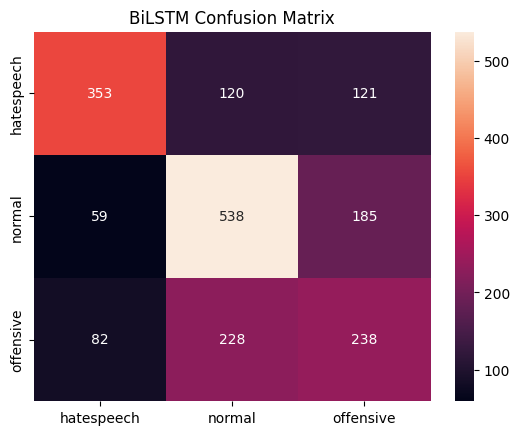

In [25]:
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=lab_enco.classes_,
            yticklabels=lab_enco.classes_)
plt.title("BiLSTM Confusion Matrix")
plt.savefig("../figures/bilstm_conf_heatmap.png",dpi=300,bbox_inches="tight" )
plt.show()


### Saved the Metrics for further analysis and model comparison.

In [26]:
with open("../results/bilstm/metrics.json", "w") as f:
    json.dump(class_repo, f, indent=4)

In [27]:
pd.DataFrame(cm, index=lab_enco.classes_, columns=lab_enco.classes_).to_csv("../results/bilstm/confusion_matrix.csv")

In [ ]:
pred_df = test_df.copy()
pred_df["predicted_label"] = lab_enco.inverse_transform(y_pred)
pred_df.to_csv("../results/bilstm/predictions.csv", index=False)

## Error Analysis

In [29]:
err_df = pred_df[pred_df["label"]!= pred_df["predicted_label"]]
err_df

,post_id,source,text,label,encoded_label,encoded,predicted_label
2,1252707503441313794_twitter,twitter,USER USER repeating little retarded,offensive,2,"[2, 2, 8452, 120, 19, 0, 0, 0, 0, 0, 0, 0, 0, ...",normal
4,1169443635869487105_twitter,twitter,USER lol not deal bms not outside children ss ...,offensive,2,"[2, 54, 3, 483, 1, 3, 887, 103, 4648, 365, 18,...",normal
7,12643541_gab,gab,black people oppressed culture community black...,offensive,2,"[20, 7, 1249, 301, 392, 76, 49, 1287, 782, 363...",normal
8,24305062_gab,gab,education marxist indoctrination since well es...,hatespeech,0,"[1617, 1151, 4895, 157, 72, 3243, 76, 4918, 33...",normal
9,1123306824571158529_twitter,twitter,fell outta love found boss bitch,normal,1,"[3220, 2144, 70, 369, 2400, 13, 0, 0, 0, 0, 0,...",offensive
...,...,...,...,...,...,...,...
1913,12128335_gab,gab,pakis found dead bradford not terrorism relate...,offensive,2,"[846, 369, 233, 8173, 3, 737, 1666, 240, 744, ...",normal
1915,5822752_gab,gab,objectively east asians upgrade intelligence m...,offensive,2,"[8797, 557, 73, 13269, 4590, 1, 7506, 4084, 61...",hatespeech
1916,1146251013822668800_twitter,twitter,USER USER ok give mestizos no welfare exchange...,offensive,2,"[2, 2, 219, 117, 6133, 8, 676, 3393, 132, 510,...",normal
1920,7672117_gab,gab,sounds like clothing line start line robes cal...,offensive,2,"[508, 6, 5374, 572, 213, 572, 12109, 99, 1521,...",normal


In [30]:
err_df.sample(200, random_state=42).to_csv("../results/bilstm/error_sample.csv",index=False)

In [31]:
torch.save(model.state_dict(), "../models/bilstm/bilstm_model.pt")

In [32]:
err_df.shape

(795, 7)

In [33]:
hate_as_off = err_df[(err_df.label == "hatespeech") & (err_df.predicted_label == "offensive")]
off_as_hate = err_df[(err_df.label == "offensive") & (err_df.predicted_label == "hatespeech")]
norm_as_off = err_df[(err_df.label == "normal") & (err_df.predicted_label == "offensive")]

In [34]:
hate_as_off.sample(5, random_state=1)[["text","label","predicted_label"]]


,text,label,predicted_label
1525,people trump playing chess american people jew...,hatespeech,offensive
987,USER lol stupid gook,hatespeech,offensive
1048,english periscope awful apparently chinese one...,hatespeech,offensive
1868,two people really getting sick tired seeing gu...,hatespeech,offensive
1336,march lives protesters trash streets c gun con...,hatespeech,offensive


In [35]:
off_as_hate.sample(5, random_state=2)[["text","label","predicted_label"]]

,text,label,predicted_label
789,anyways shit man rainbow flag represents lesbi...,offensive,hatespeech
35,fucking disgrace shameless cunts,offensive,hatespeech
802,not understand overly nice elderly far meanest...,offensive,hatespeech
312,ellison perez obama walk bar not serve kind sa...,offensive,hatespeech
1835,USER loudly_crying_face loudly_crying_face lou...,offensive,hatespeech


In [36]:
norm_as_off.sample(5, random_state=3)[["text","label","predicted_label"]]

,text,label,predicted_label
231,recognize mass immigration not politically pos...,normal,offensive
21,people calling undocumented immigrants labor u...,normal,offensive
796,look american good solid nw european descended...,normal,offensive
1762,feminists gender counter muslim males think wo...,normal,offensive
519,people recently followed no taste standards tr...,normal,offensive


# Takeaway:

- It shows strong memorization of the dataset
- The rapid gain of validation loss shows that it is not able to transfer the learned representation of training dataset on validation dataset
- I think model is not limited due to it's architecture or optimization but due to the linguistic knowledge absence.
- So i think `pretrained linguistic tokenization and transfer learning` will help it generalize well